In [1]:
from chebGreen.greenlearning.utils import DataProcessor
from chebGreen.greenlearning.model import *
from chebGreen.backend import plt
from chebGreen.utils import runCustomScript

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
%%time
example = 'laplace'
script = 'generate_example'
theta = None
Nsample = 500
lmbda = 0.01
Nf = 500
Nu = 500
noise_level = 0.1
runCustomScript(script,example,theta,Nsample,lmbda,Nf,Nu,noise_level)

### Example = laplace ###
Number of samples: 500
Length scale: 0.01
Nf: 500
Nu: 500
Noise: 10%
---------------------------------------
Step = 1/500
Step = 2/500
Step = 3/500
Step = 4/500
Step = 5/500
Step = 6/500
Step = 7/500
Step = 8/500
Step = 9/500
Step = 10/500
Step = 11/500
Step = 12/500
Step = 13/500
Step = 14/500
Step = 15/500
Step = 16/500
Step = 17/500
Step = 18/500
Step = 19/500
Step = 20/500
Step = 21/500
Step = 22/500
Step = 23/500
Step = 24/500
Step = 25/500
Step = 26/500
Step = 27/500
Step = 28/500
Step = 29/500
Step = 30/500
Step = 31/500
Step = 32/500
Step = 33/500
Step = 34/500
Step = 35/500
Step = 36/500
Step = 37/500
Step = 38/500
Step = 39/500
Step = 40/500
Step = 41/500
Step = 42/500
Step = 43/500
Step = 44/500
Step = 45/500
Step = 46/500
Step = 47/500
Step = 48/500
Step = 49/500
Step = 50/500
Step = 51/500
Step = 52/500
Step = 53/500
Step = 54/500
Step = 55/500
Step = 56/500
Step = 57/500
Step = 58/500
Step = 59/500
Step = 60/500
Step = 61/500
Step = 62/500
Step =

In [43]:
data = DataProcessor(f"datasets/{example}_noisy/data.mat")
data.generateDataset(trainRatio = 0.95)

In [51]:
F = data.trainDataset[0].cpu().numpy()
U = data.trainDataset[1].cpu().numpy()

In [59]:
A = F.T

In [60]:
u, s, v = np.linalg.svd(A)

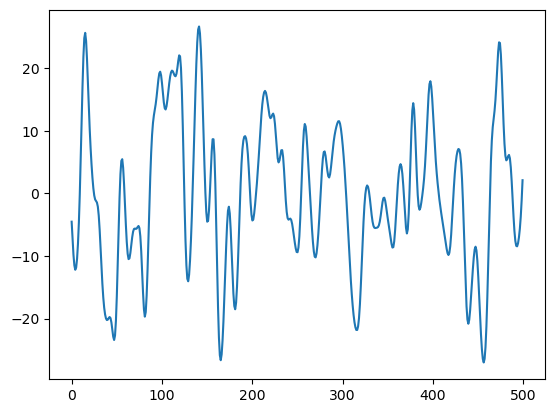

In [65]:
plt.figure()
plt.plot(A[:,0])

In [73]:
np.linalg.matrix_rank(A)

197

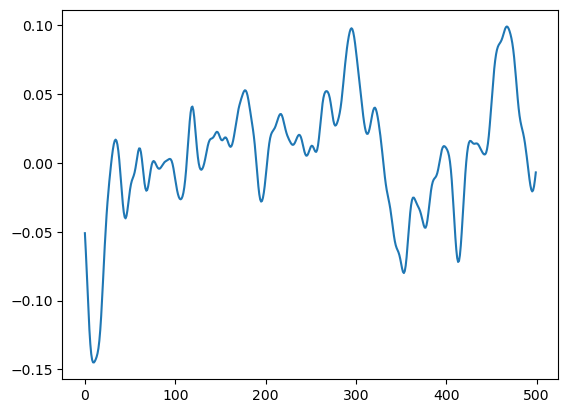

In [71]:
plt.figure()
plt.plot(u[:,3])

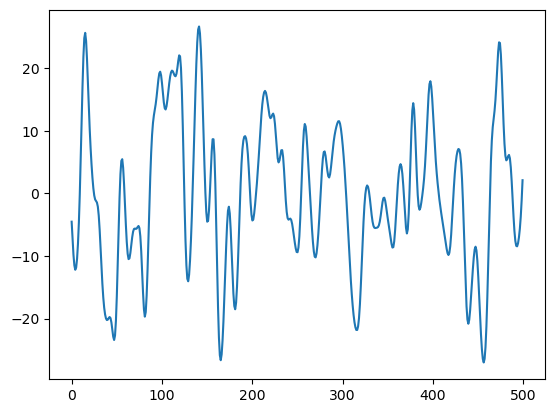

In [56]:
plt.figure()
plt.plot(F[0,:])

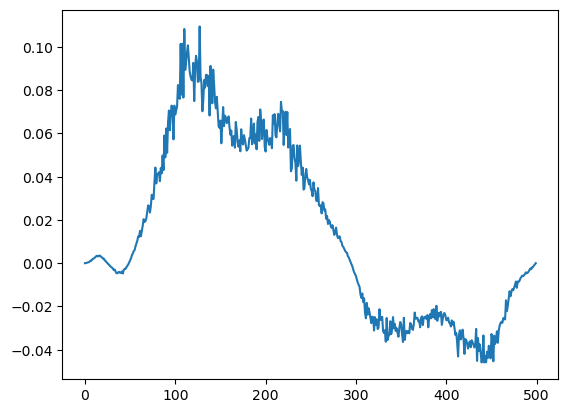

In [55]:
plt.figure()
plt.plot(U[0,:])

In [4]:
model = GreenNN()
dimension = 1
domain = [0,1,0,1]
layerConfig = [50,50,50,50]
activation = 'rational'
dirichletBC = True
model.build(dimension, domain, layerConfig, activation, dirichletBC)

In [5]:
%%time
lossHistory = model.train(data, epochs = {'adam':int(5000), 'lbfgs':int(0)})

Training with Adam:
Loss at epoch 100: Training = 3.010E-01, Validation = 2.625E-01
Loss at epoch 200: Training = 3.091E-02, Validation = 3.362E-02
Loss at epoch 300: Training = 1.663E-02, Validation = 2.069E-02
Loss at epoch 400: Training = 1.354E-02, Validation = 1.578E-02
Loss at epoch 500: Training = 1.211E-02, Validation = 1.325E-02
Loss at epoch 600: Training = 1.130E-02, Validation = 1.212E-02
Loss at epoch 700: Training = 1.079E-02, Validation = 1.138E-02
Loss at epoch 800: Training = 1.053E-02, Validation = 1.092E-02
Loss at epoch 900: Training = 1.040E-02, Validation = 1.065E-02
Loss at epoch 1000: Training = 1.031E-02, Validation = 1.048E-02
Loss at epoch 1100: Training = 1.027E-02, Validation = 1.039E-02
Loss at epoch 1200: Training = 1.022E-02, Validation = 1.029E-02
Loss at epoch 1300: Training = 1.018E-02, Validation = 1.023E-02
Loss at epoch 1400: Training = 1.016E-02, Validation = 1.019E-02
Loss at epoch 1500: Training = 1.013E-02, Validation = 1.015E-02
Loss at epoch 

In [6]:
xF, xU = data.xF, data.xU
x, y = np.meshgrid(xU, xF)
G = model.evaluateG(x,y)
N = model.evaluateN(data.xF)

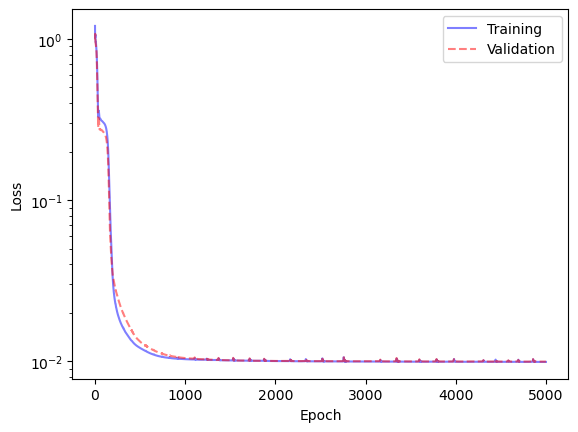

In [7]:
plt.figure()
plt.semilogy(range(len(lossHistory['training'])), lossHistory['training'], 'b', alpha = 0.5)
plt.semilogy(range(len(lossHistory['validation'])), lossHistory['validation'], 'r--', alpha = 0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])

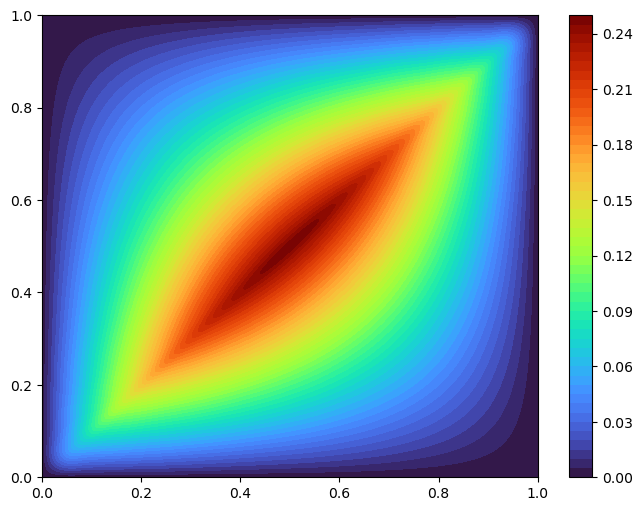

In [11]:
fig = plt.figure(figsize = (8,6))
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = np.min(G), vmax = np.max(G))
plt.colorbar()

In [12]:
model.saveModels(f'savedModels/{example}')

In [13]:
savedModel = GreenNN()
savedModel.build(dimension, domain, layerConfig, activation, dirichletBC, loadPath = f'savedModels/{example}')

In [30]:
from chebGreen.chebpy2 import Chebfun2
from chebGreen.chebpy2.chebpy.core.algorithms import chebpts2
from chebGreen.chebpy2.chebpy.api import chebfun

In [31]:
%%time
cheb2prefs = Chebpy2Preferences()
cheb2prefs.prefx.eps = 1e-6
cheb2prefs.prefx.eps = 1e-6
g = Chebfun2(savedModel.evaluateG, domain = domain, prefs = cheb2prefs, simplify = False)

CPU times: user 329 ms, sys: 91.4 ms, total: 421 ms
Wall time: 523 ms


In [32]:
def vec2cheb(f, x):
    f = f.reshape((-1))
    x = x.reshape((-1))
    domain = [np.min(x), np.max(x)] # Compute the bounds of the domain
    
    # Function is resampled at twice as many sampled points to maintain accuracy in a different basis.
    N = 2 * f.shape[0] # Check if this is fine
    
    # Compute the Chebyshev nodes and scale them to the domain
    xc = (chebpts2(N) + 1) * ((domain[1] - domain[0])/2) + domain[0]

    # Compute the interpolated value of the function at the Chebyshev nodes
    fc = np.interp(xc, x, f).reshape((-1,1))

    return chebfun(fc, domain)

In [33]:
def computeEmpiricalError(data, G, N = None):
    RE, UC, U0 = [],[],[]
    if N is None:
        print('Assuming a zero homogeneous solution.')
    for i in range(data.valDataset[1].cpu().numpy().shape[0]):
        xF, xU = data.xF, data.xU
        f, u  = data.valDataset[0].cpu().numpy()[i,:], data.valDataset[1].cpu().numpy()[i,:]
        f0, u0 = vec2cheb(f,xF), vec2cheb(u,xU)
        if N is None:
            uc = G.T.integralTransform(f0)
        else:
            uc = G.T.integralTransform(f0) + N
        re = (uc - u0).abs()/u0.abs().sum()
        RE.append(re)
    
    error = np.mean([re.sum() for re in RE])
    return error

In [34]:
error = computeEmpiricalError(data, g, N = None)

Assuming a zero homogeneous solution.


0.06590319638549089

In [39]:
%%time
example = 'laplace'
script = 'generate_example'
theta = None
Nsample = 100
lmbda = 0.01
Nf = 500
Nu = 500
noise_level = 0
runCustomScript(script,example,theta,Nsample,lmbda,Nf,Nu,noise_level)

### Example = laplace ###
Number of samples: 100
Length scale: 0.01
Nf: 500
Nu: 500
Noise: 0%
---------------------------------------
Step = 1/100
Step = 2/100
Step = 3/100
Step = 4/100
Step = 5/100
Step = 6/100
Step = 7/100
Step = 8/100
Step = 9/100
Step = 10/100
Step = 11/100
Step = 12/100
Step = 13/100
Step = 14/100
Step = 15/100
Step = 16/100
Step = 17/100
Step = 18/100
Step = 19/100
Step = 20/100
Step = 21/100
Step = 22/100
Step = 23/100
Step = 24/100
Step = 25/100
Step = 26/100
Step = 27/100
Step = 28/100
Step = 29/100
Step = 30/100
Step = 31/100
Step = 32/100
Step = 33/100
Step = 34/100
Step = 35/100
Step = 36/100
Step = 37/100
Step = 38/100
Step = 39/100
Step = 40/100
Step = 41/100
Step = 42/100
Step = 43/100
Step = 44/100
Step = 45/100
Step = 46/100
Step = 47/100
Step = 48/100
Step = 49/100
Step = 50/100
Step = 51/100
Step = 52/100
Step = 53/100
Step = 54/100
Step = 55/100
Step = 56/100
Step = 57/100
Step = 58/100
Step = 59/100
Step = 60/100
Step = 61/100
Step = 62/100
Step = 

In [40]:
data = DataProcessor(f"datasets/{example}/data.mat")
data.generateDataset(trainRatio = 0.1)

In [41]:
%%time
error = computeEmpiricalError(data, g, N = None)

Assuming a zero homogeneous solution.
CPU times: user 1min 14s, sys: 2min 41s, total: 3min 56s
Wall time: 47.1 s


In [42]:
error

0.003741926823858058

In [12]:
xx = np.linspace(domain[2],domain[3],2000)
yy = np.linspace(domain[0],domain[1],2000)
x, y = np.meshgrid(xx,yy)
G = savedModel.evaluateG(x,y)
N = savedModel.evaluateN(xx)

In [13]:
def green(x,s):
    g = 0
    g = (x <= s) * (x * (1-s)) + (x > s) * (s * (1-x))
    # np.random.seed(42)
    # g = g + np.random.normal(loc = 0.0, scale = 0.25 * eps * factor, size=x.shape)
    return g

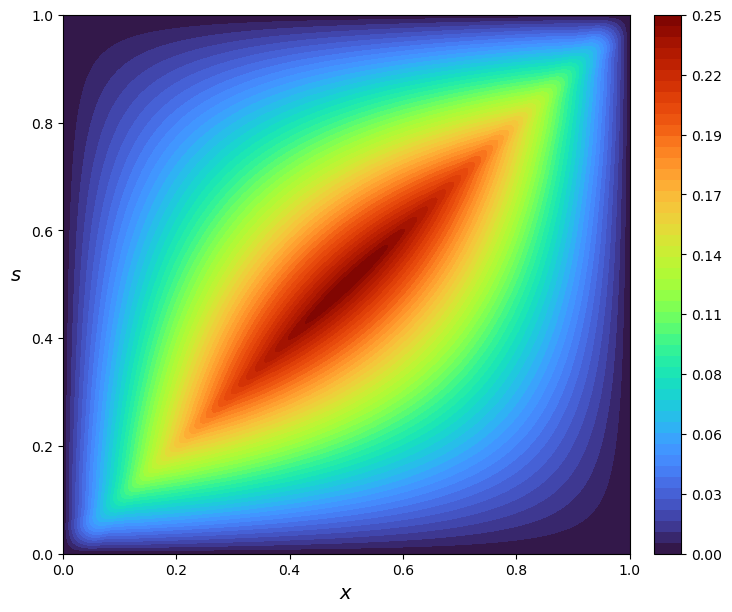

In [54]:
fig = plt.figure(figsize = (8,7))

vmin, vmax = np.min(G), np.max(G)

levels = np.linspace(vmin, vmax, 50, endpoint = True)
plt.contourf(x,y,G, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)

ticks = np.linspace(vmin, vmax, 10, endpoint=True)
cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])

plt.xlabel(f'$x$', fontsize = 14)
plt.ylabel(f'$s$', rotation='horizontal', labelpad=11, fontsize = 14)
# plt.title("Data", fontsize = 14)
# fig.savefig(f'G.png', dpi = fig.dpi)

Text(0, 0.5, '$s$')

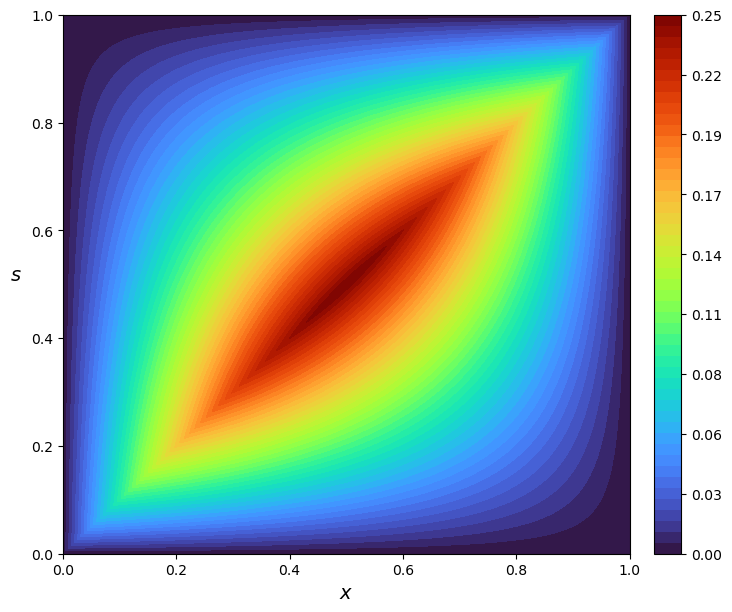

In [17]:
Gexact = green(x,y)

fig = plt.figure(figsize = (8,7))

vmin, vmax = np.min(Gexact), np.max(Gexact)

levels = np.linspace(vmin, vmax, 50, endpoint = True)
plt.contourf(x,y,Gexact, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)

ticks = np.linspace(vmin, vmax, 10, endpoint=True)
cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])

plt.xlabel(f'$x$', fontsize = 14)
plt.ylabel(f'$s$', rotation='horizontal', labelpad=11, fontsize = 14)
# plt.title("Data", fontsize = 14)

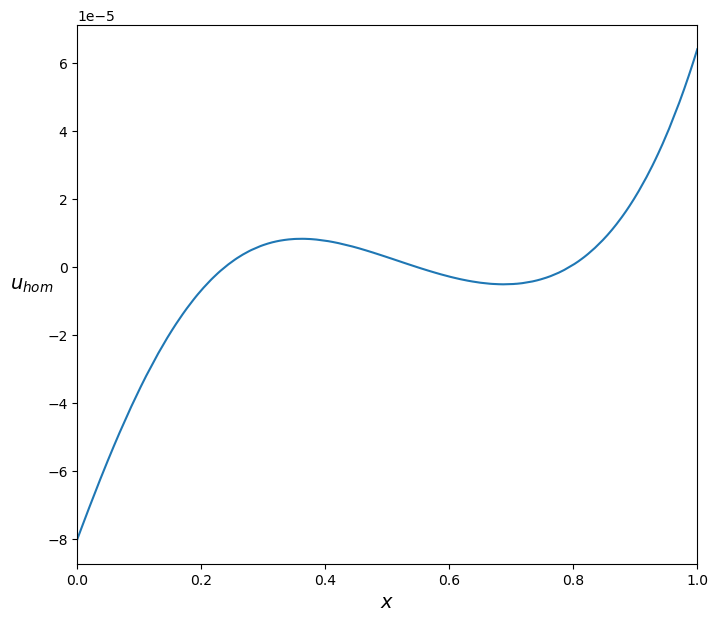

In [55]:
fig = plt.figure(figsize = (8,7))
plt.plot(xx,N)
plt.xlabel(f'$x$', fontsize = 14)
plt.ylabel(f'$u_{{hom}}$', rotation='horizontal', labelpad=11, fontsize = 14)
plt.xlim([0,1])
fig.savefig(f'u_hom.png', dpi = fig.dpi)

In [20]:
np.sqrt(np.linalg.norm(G-Gexact)/np.linalg.norm(Gexact))

0.060128703379311005

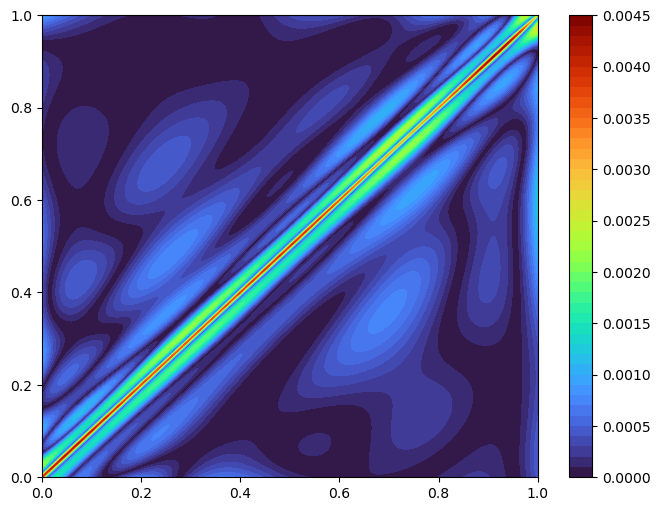

In [16]:
fig = plt.figure(figsize = (8,6))
plt.contourf(x,y,np.abs(G-Gexact), 50, cmap = 'turbo')
plt.colorbar()